In [ ]:
import random
import pandas as pd
import os

import numpy as np
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
 
df = pd.read_csv("stratisfied_with_scanner_0_embed_evaluation_results.csv")
df["experiment_name"] = "Trained on S. Dimensions"

In [ ]:
df.columns


Index(['model_type', 'model_name', 'counterfactual_scanner', 'iid_accuracy',
       'iid_balanced_accuracy', 'iid_auc', 'iid_recall', 'iid_specificity',
       'true_ood_accuracy', 'true_ood_balanced_accuracy', 'true_ood_auc',
       'true_ood_recall', 'true_ood_specificity', 'cf_accuracy',
       'cf_balanced_accuracy', 'cf_auc', 'cf_recall', 'cf_specificity',
       'atc_pred', 'atc_mae', 'doc_pred', 'doc_mae'],
      dtype='object')

--- Accuracy Analysis for Trained on S. Dimensions ---
Correlation (r): 0.8095, p-value: 0.0003

--- AUC Analysis for Trained on S. Dimensions ---
Correlation (r): 0.7489, p-value: 0.0013

--- Recall Analysis for Trained on S. Dimensions ---
Correlation (r): 0.7416, p-value: 0.0016

--- Specificity Analysis for Trained on S. Dimensions ---
Correlation (r): 0.7040, p-value: 0.0034


All plots saved to correlation_plot_embed_scanner_2x2.pdf


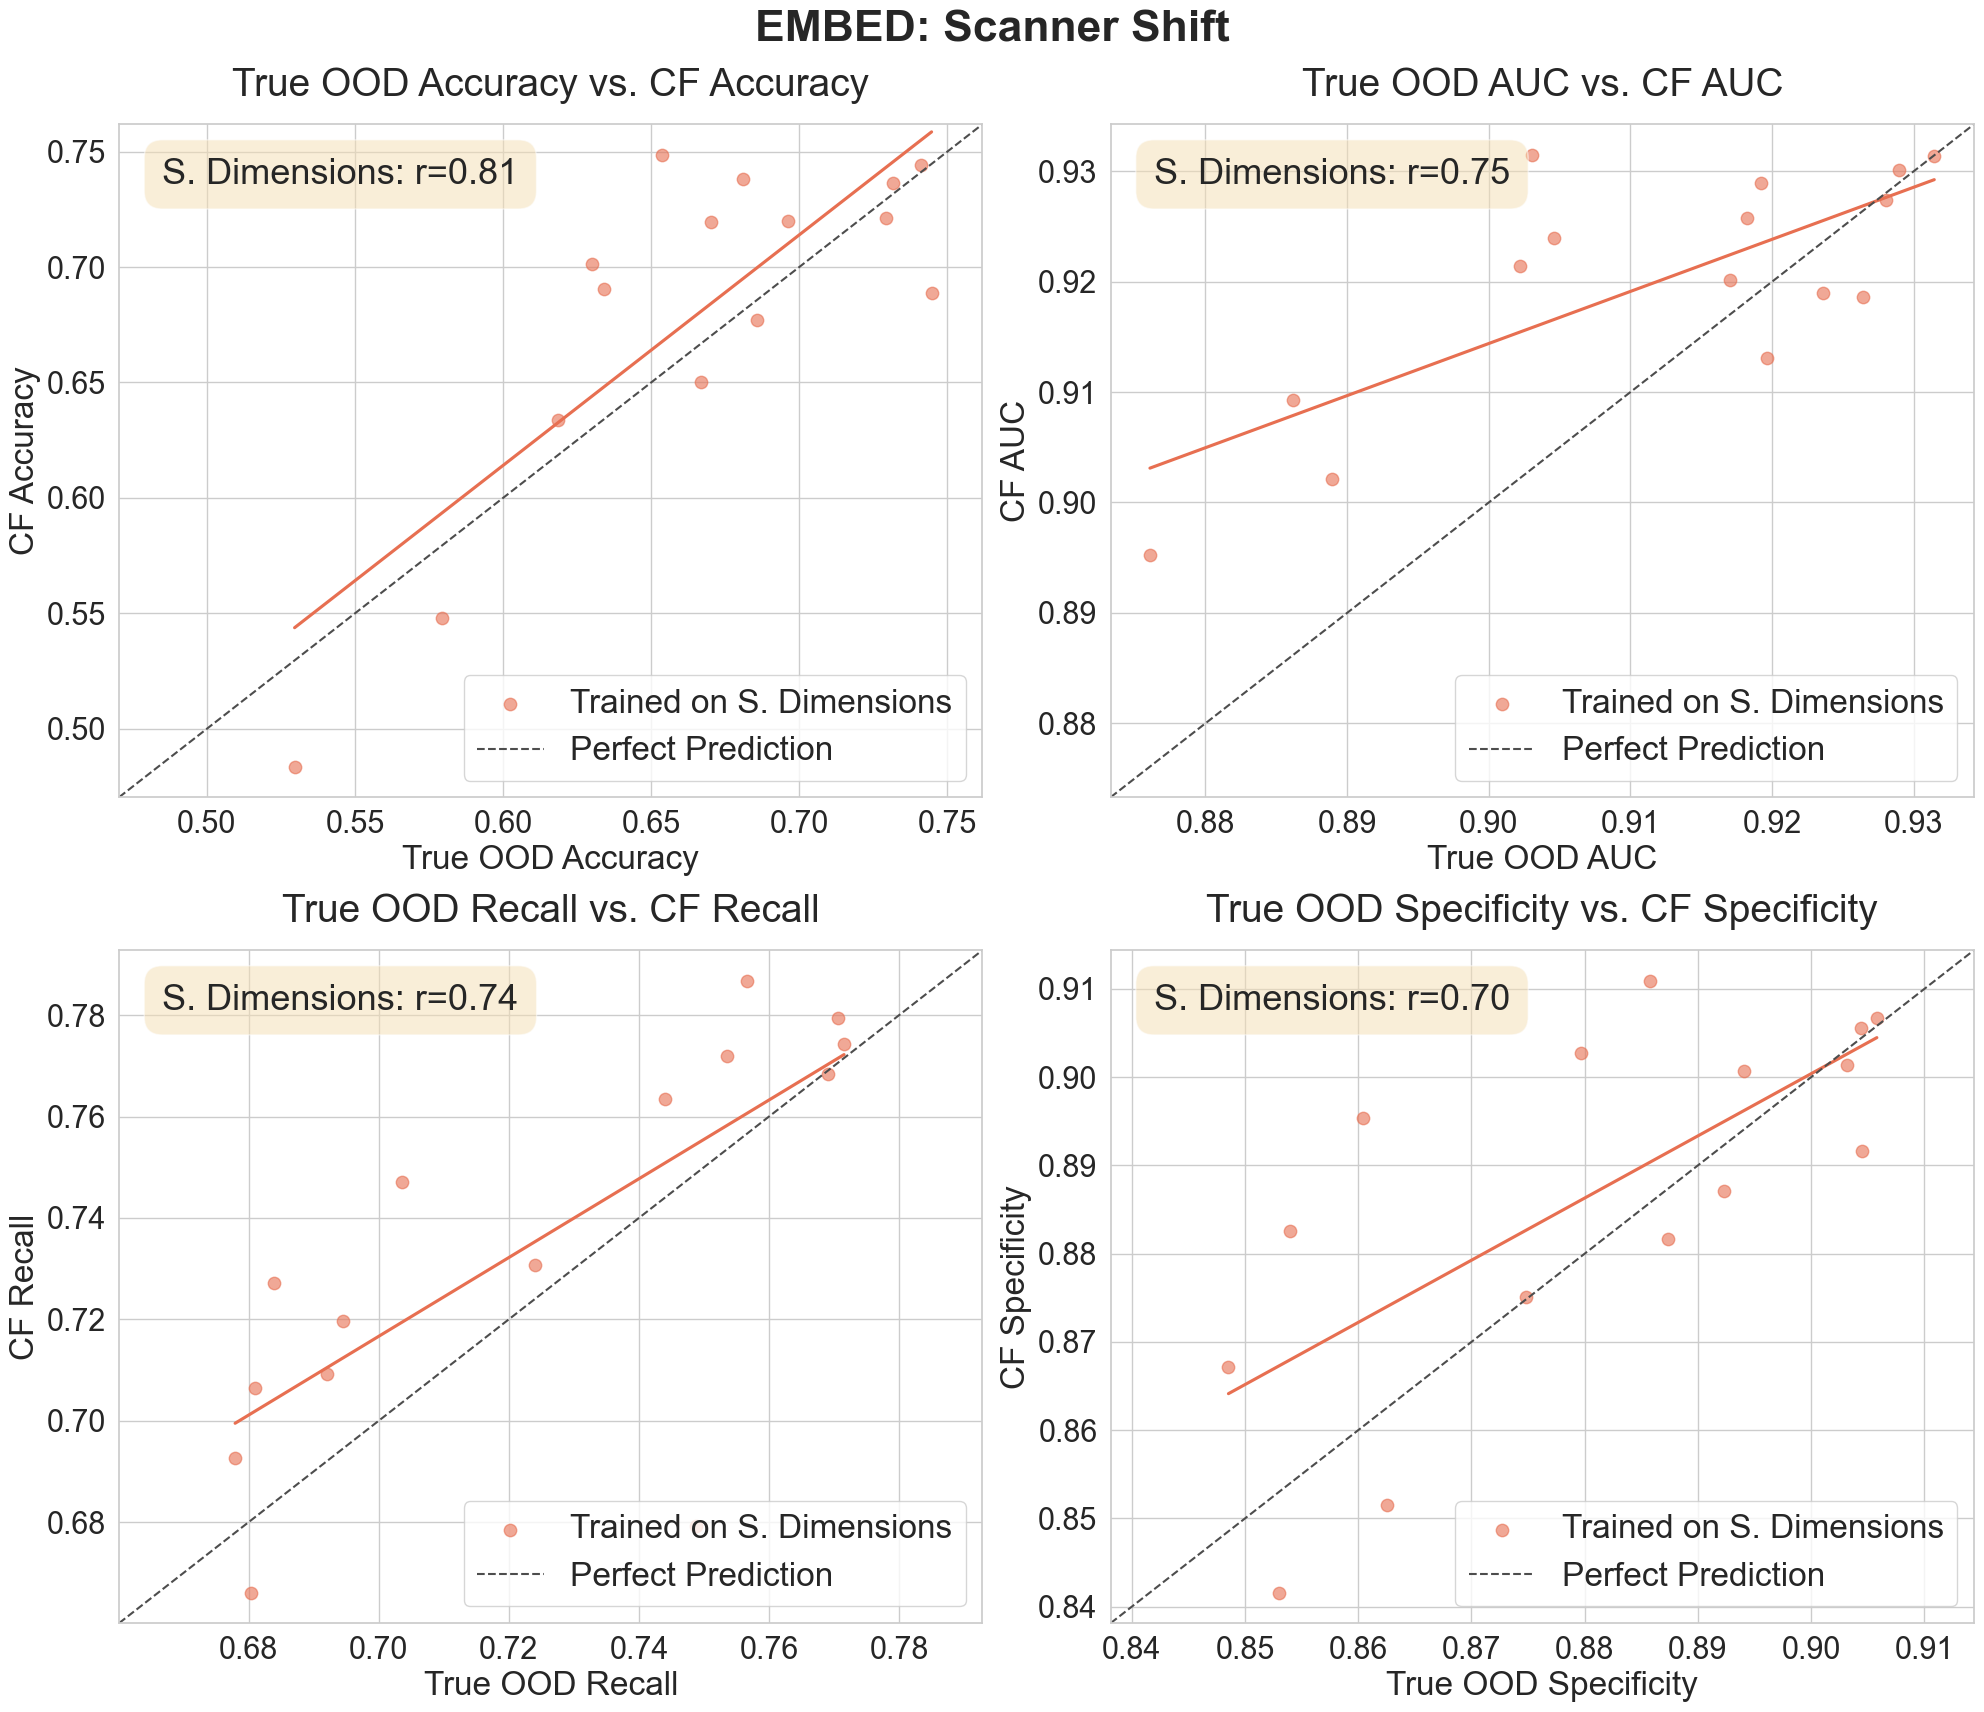

In [ ]:
def create_correlation_plot(ax, dataframe, true_col, pred_col, metric_name):
    """
    Generates a scatter plot with regression lines for each group in 'experiment_name'.

    Args:
        ax (matplotlib.axes.Axes): The Axes object to draw the plot on.
        dataframe (pd.DataFrame): The dataframe containing the data.
        true_col (str): The name of the column with true values.
        pred_col (str): The name of the column with predicted values.
        metric_name (str): The human-readable name of the metric (e.g., "AUC").
    """
    sns.set_theme(style="whitegrid")
    
    groups = dataframe['experiment_name'].unique()
    colors = ['#e76f51', '#2a9d8f'] 
    labels = {
        'Trained on Male Subset': 'Trained on Male Subset',
        'Trained on Female Subset': 'Trained on Female Subset'
    }
    
    correlation_texts = []

    for i, group_name in enumerate(groups):
        group_df = dataframe[dataframe['experiment_name'] == group_name]
        
        clean_df = group_df[[true_col, pred_col]].dropna()
        if clean_df.empty:
            print(f"Skipping {metric_name} plot for group {group_name}: No valid data.")
            continue

        r, p_value = pearsonr(clean_df[true_col], clean_df[pred_col])
        print(f"--- {metric_name} Analysis for {group_name} ---")
        print(f"Correlation (r): {r:.4f}, p-value: {p_value:.4f}\n")
        
        group_label_short = 'IDC' if 'IDC' in group_name else 'S. Dimensions'
        correlation_texts.append(f'{group_label_short}: r={r:.2f}')

        sns.regplot(
            data=clean_df,
            x=true_col,
            y=pred_col,
            scatter_kws={'alpha': 0.6, 's': 80},
            ci=None,
            ax=ax,
            color=colors[i],
            label=labels.get(group_name, group_name)
        )

 
    all_vals = pd.concat([dataframe[true_col], dataframe[pred_col]]).dropna()
    min_val, max_val = all_vals.min(), all_vals.max()
    buffer = (max_val - min_val) * 0.05
    ax.plot([min_val - buffer, max_val + buffer], [min_val - buffer, max_val + buffer], ls="--", c=".3", label="Perfect Prediction")

    text_str = '\n'.join(correlation_texts)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=26,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    ax.set_title(f'True OOD {metric_name} vs. CF {metric_name}', fontsize=28, pad=20)
    ax.set_xlabel(f'True OOD {metric_name}', fontsize=24)
    ax.set_ylabel(f'CF {metric_name}', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=22) 

    ax.set(xlim=(min_val - buffer, max_val + buffer), ylim=(min_val - buffer, max_val + buffer))
    ax.legend(fontsize=24, loc="lower right")

if 'df' in locals() and not df.empty:
    metrics = {
        'Accuracy': ('true_ood_accuracy', 'cf_accuracy'),
        'AUC': ('true_ood_auc', 'cf_auc'),
        'Recall': ('true_ood_recall', 'cf_recall'),
        'Specificity': ('true_ood_specificity', 'cf_specificity')
    }

    fig, axes = plt.subplots(2, 2, figsize=(20, 18))

    axes_flat = axes.flatten()
    metric_keys = list(metrics.keys())

    for i in range(len(metric_keys)):
        metric_name = metric_keys[i]
        true_col, pred_col = metrics[metric_name]
        create_correlation_plot(axes_flat[i], df, true_col, pred_col, metric_name)

    
    fig.suptitle(
        'EMBED: Scanner Shift',
        fontsize=32, 
        fontweight='bold',
        y=0.95 
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    output_filename = "correlation_plot_embed_scanner_2x2.pdf"
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"\nAll plots saved to {output_filename}")
    plt.show()

else:
    print("DataFrame 'df' not found. Please load your data first.")